In [304]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import io

In [305]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [306]:
# Code to read csv file 
comments=pd.read_csv('data/cleaned_comments_all2.csv')

In [307]:
# delete all comments with 1 like or less
comments=comments[comments.likeCount > 1]
# delete all comments written in other languages
comments=comments[comments['language_y']=='en']

In [308]:
comments.reset_index(inplace=True)

In [309]:
comments.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [310]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58996 entries, 0 to 58996
Data columns (total 20 columns):
index            58996 non-null int64
Unnamed: 0       58996 non-null int64
id               58996 non-null object
commentAuthor    58996 non-null object
videoId          58996 non-null object
commentYear      58996 non-null int64
commentMonth     58996 non-null int64
commentDay       58996 non-null int64
likeCount        58996 non-null int64
channelId        58996 non-null object
videoTags        58996 non-null object
channelTitle     58996 non-null object
videoYear        58996 non-null float64
videoMonth       58996 non-null float64
videoViews       58996 non-null float64
text             58996 non-null object
community        58996 non-null int64
language_y       58996 non-null object
translation      58996 non-null object
cleaned          58996 non-null object
dtypes: float64(3), int64(7), object(10)
memory usage: 9.5+ MB


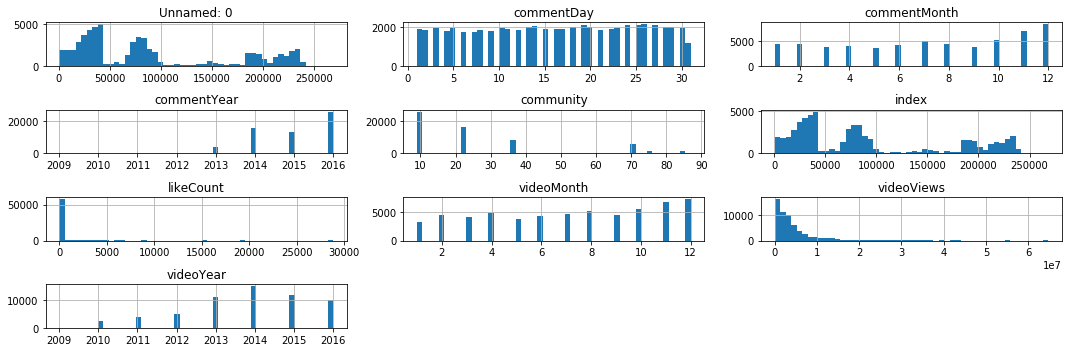

In [311]:
comments.hist(bins=50, figsize=(15,5))
plt.tight_layout()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6f09ed780>,
      dtype=object)

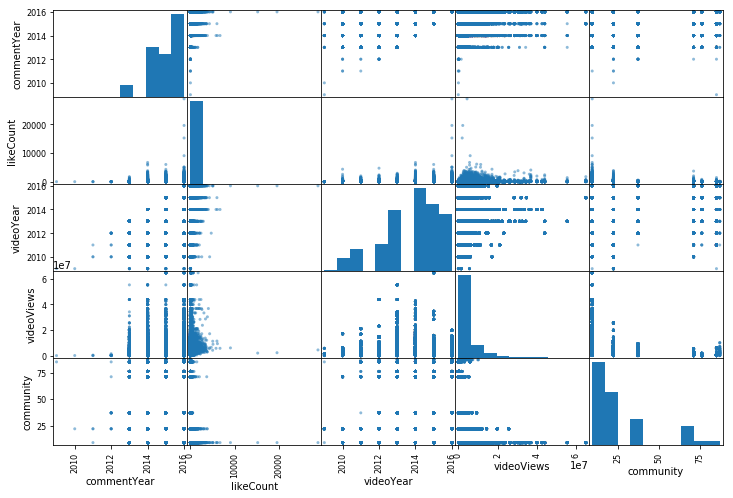

In [312]:
from pandas.plotting import scatter_matrix

attributes = ['commentYear', 'likeCount' ,'videoYear','videoViews','community']
scatter_matrix(comments[attributes], figsize=(12, 8))

In [313]:
comments.cleaned[12:20]

12                 memories blue xephos much nostalgia 
13                                     back lewis noob 
14    remember correctly videos one main reasons lea...
15                                     simon smart one 
16    back minecraft fun mainly survival games mini-...
17                                   literally classic 
18                              else rewatching series 
19                 remember watched years ago miss tbh 
Name: cleaned, dtype: object

In [314]:
comments.drop(labels=['Unnamed: 0','language_y','translation'], axis=1,inplace=True)

In [315]:
comments.columns

Index(['index', 'id', 'commentAuthor', 'videoId', 'commentYear',
       'commentMonth', 'commentDay', 'likeCount', 'channelId', 'videoTags',
       'channelTitle', 'videoYear', 'videoMonth', 'videoViews', 'text',
       'community', 'cleaned'],
      dtype='object')

Add column to check if the commenter is the author or channel that posted one of the trending videos

In [316]:
s=comments.channelId.value_counts().index.tolist()

In [317]:
comments['isAuthorVideo']=comments.commentAuthor.apply(lambda x: x in s)

In [318]:
comments.isAuthorVideo.value_counts()

False    58741
True       255
Name: isAuthorVideo, dtype: int64

## Categorize variable like count

In [319]:
comments.likeCount.quantile([0.2,0.4,0.6,0.8,0.9])

0.2      3.0
0.4      5.0
0.6     14.0
0.8     51.0
0.9    124.0
Name: likeCount, dtype: float64

In [320]:
bins=[1,3,5,14,51,124, np.inf]
names=['2-3','4-5','6-14','15-51','52-124','125-28088']
comments['likeClasses'] = pd.cut(comments['likeCount'], bins, labels=names, 
                                 right=True)

In [321]:
comments.likeClasses.value_counts()/len(comments)

2-3          0.280680
6-14         0.203438
15-51        0.193674
4-5          0.124432
125-28088    0.099922
52-124       0.097854
Name: likeClasses, dtype: float64

## Categorize variable community

In [322]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
likeClasses = comments.likeClasses
le = LabelEncoder()
like_encoded=le.fit_transform(likeClasses)

In [323]:
comments.drop(['videoTags'],axis=1,inplace=True)
comments.drop(['channelTitle'], axis=1, inplace=True)

## Creating variables comment length and char

In [324]:
comments['commentLength']=comments.text.apply(lambda x: len(x.split()))

In [325]:
comments['charLength']=comments.text.apply(lambda x:len(x) )

In [326]:
comments.drop(['id'],axis=1,inplace=True)
comments.drop(['text'],axis=1,inplace=True)

In [327]:
comments.drop(['likeClasses'],axis=1,inplace=True)

In [328]:
comments.columns

Index(['index', 'commentAuthor', 'videoId', 'commentYear', 'commentMonth',
       'commentDay', 'likeCount', 'channelId', 'videoYear', 'videoMonth',
       'videoViews', 'community', 'cleaned', 'isAuthorVideo', 'commentLength',
       'charLength'],
      dtype='object')

## Add embeding with word2vec

In [329]:
import numpy
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models import Word2Vec

### Using the vocabulary provided by the same comments

In [330]:
sentences=comments.cleaned.apply(lambda x: x.split()).tolist()
model= Word2Vec(sentences)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [331]:
similar_words = model.most_similar('old')
print(similar_words)

[('miss', 0.9152673482894897), ('ol', 0.9063053131103516), ('days', 0.8892701864242554), ('ole', 0.884341835975647), ('ah', 0.8840513229370117), ('ahh', 0.8809301853179932), ('good', 0.8573359251022339), ('memories', 0.8474450707435608), ('personalities', 0.8352455496788025), ('sky', 0.8308360576629639)]


In [332]:
dissimlar_words = model.doesnt_match(['gamer', 'youtuber', 'lp', 'please'])
print(dissimlar_words)

please


In [333]:
similar = model.similar_by_word('lose')
print(similar)

[('mad', 0.996613085269928), ('okay', 0.9955762028694153), ('cause', 0.9955294132232666), ('stand', 0.9949883222579956), ('tired', 0.994465172290802), ('telling', 0.9942898750305176), ('dating', 0.9940150380134583), ('spoilers', 0.9929722547531128), ('cuz', 0.9925074577331543), ('happens', 0.9924617409706116)]


In [334]:
w2v['noob']

array([ 0.27481264, -0.20679942,  0.0027811 , -0.10080836,  0.2825214 ,
        0.10537706, -0.12342405, -0.19630359,  0.02604649,  0.14603442,
       -0.03443415, -0.12850712, -0.22855608,  0.17429304,  0.18214832,
        0.02152368,  0.05764313,  0.28480983,  0.3012451 ,  0.1144025 ,
        0.41124144, -0.18805312, -0.2348755 , -0.34211144, -0.02509572,
        0.35465103, -0.2063741 , -0.25602183,  0.28348815, -0.12294787,
       -0.24045908, -0.12759271,  0.14693324, -0.05770347, -0.04435356,
        0.327022  , -0.17246135,  0.02728998, -0.06115655, -0.26250967,
       -0.07581861,  0.14252113,  0.05790742, -0.04703137,  0.11299355,
        0.0564165 , -0.10273403,  0.02366109, -0.3076976 , -0.07862013,
       -0.09589317,  0.09357141,  0.05272765,  0.02467748,  0.374079  ,
        0.03689453, -0.37189442, -0.05065564, -0.0820476 , -0.08465633,
        0.0114582 , -0.08375335, -0.17926772,  0.11697725,  0.19177864,
        0.14153105,  0.11612222, -0.04676969, -0.08398061,  0.27

### Using wiki corpus latest english articles

In [335]:
# wiki = WikiCorpus('data/enwiki-latest-pages-articles.xml.bz2', 
#                   lemmatize=False, dictionary={})
# sentences = list(wiki.get_texts())
# params = {'size': 200, 'window': 10, 'min_count': 10, 
#           'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,}
# word2vec = Word2Vec(sentences, **params)

### Method to process comments using language model

In [336]:
from sklearn.base import BaseEstimator, TransformerMixin

In [337]:
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        for words in X:
            print (type(X))

        arr= np.array([
            np.mean([self.word2vec[w] for w in words.split() if w in self.word2vec]
                    or [np.zeros(100)], axis=0)
            for words in X.cleaned
        ])
        print(arr.shape)
        return (arr)

## Transform columns and merge dataset

In [338]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [339]:
num_pipeline = Pipeline([
        ('std_scaler', MinMaxScaler([0,1])),
])

In [340]:
cat_pipeline = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
])

In [341]:
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [342]:
text_pipeline=Pipeline([
    ('word2vec',MeanEmbeddingVectorizer(w2v) ),
    ('std_scaler', MinMaxScaler([0,1])),
])

In [343]:
num_attribs = ['commentMonth', 'commentDay', 'videoYear', 'videoMonth', 
               'videoViews', 'commentLength','charLength','commentYear']
cat_attribs = ["community",'videoId','isAuthorVideo']
cat_attribs2=['channelId']
text_attribs= ['cleaned']

full_pipeline = ColumnTransformer([
  ("num", num_pipeline, num_attribs),
  ("cat", cat_pipeline, cat_attribs),
  ("cat2", ModifiedLabelEncoder(), cat_attribs2),
  ("word2vec vectorizer", text_pipeline, text_attribs),
])

comments_prepared = full_pipeline.fit_transform(comments)


<class 'pandas.core.frame.DataFrame'>
(58996, 100)


## Creating new dataset with Count Vectorizer (BOW)

In [344]:
count_vect = CountVectorizer(ngram_range=(1,2),dtype=np.int64)
text_counts = count_vect.fit_transform(comments.cleaned)
tfidf_transformer = TfidfTransformer(use_idf=True)
X_train_tfidf = tfidf_transformer.fit_transform(text_counts)

In [345]:
print(X_train_tfidf.shape)
print(comments_prepared.shape)

(58996, 264423)
(58996, 2710)


## Split train and test set

### Merged dataset with BOW

In [346]:
from sklearn.model_selection import train_test_split

In [347]:
X= text_counts
y= like_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=like_encoded)

In [348]:
print(str(X_train.shape)+"+"+str(X_test.shape))

(47196, 264423)+(11800, 264423)


In [349]:
print(str(y_train.shape)+"+"+str(y_test.shape))

(47196,)+(11800,)


### Merged dataset with Word2vec

In [350]:
X= comments_prepared
y = like_encoded
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X, y, test_size=0.2, random_state=0, stratify=like_encoded)

In [351]:
print(str(X_train_w2v.shape)+"+"+str(X_test_w2v.shape))

(47196, 2710)+(11800, 2710)


In [352]:
print(str(y_train_w2v.shape)+"+"+str(y_test_w2v.shape))

(47196,)+(11800,)


## Train Classifiers

In [369]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Import evaluation metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
import seaborn as sns

### 1. Logistic Regression

In [354]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

In [355]:
y_pred=clf.predict(X_test)

In [356]:
cm_bow = confusion_matrix(y_test, y_pred) 
cm_bow

array([[ 219,  255,  382,   42,  105,  176],
       [ 173,  476,  940,  116,  137,  443],
       [ 113,  419, 1990,  153,   90,  547],
       [  47,  223,  784,   70,   56,  288],
       [ 160,  259,  400,   47,   81,  208],
       [  93,  439, 1217,  108,   73,  471]])

In [357]:
print(np.mean(y_pred == y_test))

0.2802542372881356


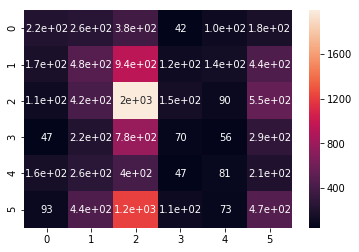

In [358]:
sns.heatmap(cm_bow, annot=True)

In [359]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.27      0.19      0.22      1179
           1       0.23      0.21      0.22      2285
           2       0.35      0.60      0.44      3312
           3       0.13      0.05      0.07      1468
           4       0.15      0.07      0.10      1155
           5       0.22      0.20      0.21      2401

   micro avg       0.28      0.28      0.28     11800
   macro avg       0.23      0.22      0.21     11800
weighted avg       0.25      0.28      0.25     11800



#### --------- W2V dataset

In [361]:
log_reg2=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train_w2v, y_train_w2v)

In [362]:
y_pred_w2v=log_reg2.predict(X_test_w2v)

In [365]:
cm_w2v = confusion_matrix(y_test_w2v, y_pred_w2v) 
cm_w2v

array([[  62,  714,  400,    0,    0,    3],
       [  23,  947, 1290,    0,    0,   25],
       [   5,  508, 2779,    0,    0,   20],
       [   5,  376, 1080,    0,    0,    7],
       [  31,  613,  504,    0,    0,    7],
       [   7,  701, 1673,    0,    0,   20]])

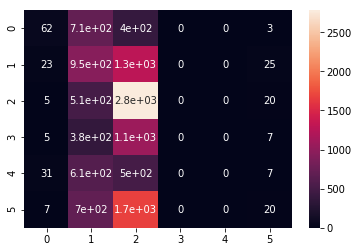

In [366]:
sns.heatmap(cm_w2v, annot=True)

In [367]:
print(classification_report(y_test_w2v,y_pred_w2v))

              precision    recall  f1-score   support

           0       0.47      0.05      0.09      1179
           1       0.25      0.41      0.31      2285
           2       0.36      0.84      0.50      3312
           3       0.00      0.00      0.00      1468
           4       0.00      0.00      0.00      1155
           5       0.24      0.01      0.02      2401

   micro avg       0.32      0.32      0.32     11800
   macro avg       0.22      0.22      0.15     11800
weighted avg       0.24      0.32      0.21     11800



### 2. Multinomial Naive Bayes

#### --------- BOW dataset

In [279]:
multinomialNB = MultinomialNB()
multinomialNB.fit(X_train, y_train) 
  
# predicting test set results 
y_pred = multinomialNB.predict(X_test) 
  
# making the confusion matrix 
cm_bow = confusion_matrix(y_test, y_pred) 
cm_bow

array([[ 105,  481,  388,    7,   26,  172],
       [  55,  745, 1074,   30,   28,  353],
       [  35,  686, 2080,   43,   14,  454],
       [  17,  340,  872,   13,    9,  217],
       [  65,  450,  435,    8,   19,  178],
       [  29,  644, 1312,   19,   22,  375]])

In [ ]:
print(np.mean(y_pred == y_test))

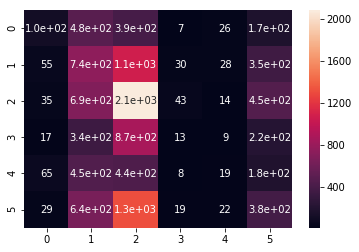

In [280]:
sns.heatmap(cm_bow, annot=True)

In [281]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.09      0.14      1179
           1       0.22      0.33      0.26      2285
           2       0.34      0.63      0.44      3312
           3       0.11      0.01      0.02      1468
           4       0.16      0.02      0.03      1155
           5       0.21      0.16      0.18      2401

   micro avg       0.28      0.28      0.28     11800
   macro avg       0.23      0.20      0.18     11800
weighted avg       0.25      0.28      0.23     11800



#### ---------- W2V dataset

In [263]:
classifier = MultinomialNB(alpha=1, fit_prior=True)
classifier.fit(X_train_w2v.toarray(), y_train_w2v) 
  
# predicting test set results 
y_pred_w2v = classifier.predict(X_test_w2v.toarray()) 
  
# making the confusion matrix 
cm = confusion_matrix(y_test_w2v, y_pred_w2v) 
cm

array([[ 580,  249,  206,    4,   64,   76],
       [ 480,  551,  821,   18,  100,  315],
       [ 368,  341, 2136,   43,   99,  325],
       [ 180,  209,  766,   12,   58,  243],
       [ 377,  323,  281,    2,   67,  105],
       [ 321,  473, 1093,   22,  102,  390]])

In [282]:
print(np.mean(y_pred_w2v == y_test_w2v))

0.31661016949152543


### Evaluation gaussian NB ---- W2V dataset

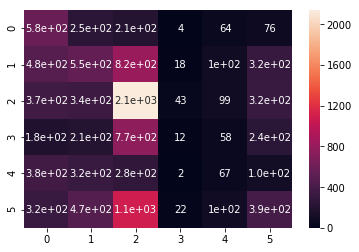

In [266]:
sns.heatmap(cm, annot=True)

In [267]:
print(classification_report(y_test_w2v,y_pred_w2v))

              precision    recall  f1-score   support

           0       0.25      0.49      0.33      1179
           1       0.26      0.24      0.25      2285
           2       0.40      0.64      0.50      3312
           3       0.12      0.01      0.02      1468
           4       0.14      0.06      0.08      1155
           5       0.27      0.16      0.20      2401

   micro avg       0.32      0.32      0.32     11800
   macro avg       0.24      0.27      0.23     11800
weighted avg       0.27      0.32      0.27     11800



### 3. Support vector machine

#### --------- BOW dataset

In [287]:
lin_clf = svm.LinearSVC()
#Train the model using the training sets
lin_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = lin_clf.predict(X_test)

In [288]:
# making the confusion matrix 
cm = confusion_matrix(y_test, y_pred) 
cm

array([[ 245,  240,  304,   78,  129,  183],
       [ 213,  468,  797,  185,  191,  431],
       [ 148,  471, 1686,  268,  134,  605],
       [  72,  221,  673,  129,   89,  284],
       [ 178,  245,  336,   80,  114,  202],
       [ 135,  437, 1026,  219,  121,  463]])

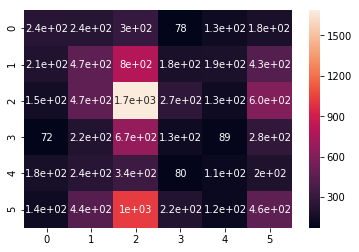

In [289]:
sns.heatmap(cm, annot=True)

In [291]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.25      0.21      0.23      1179
           1       0.22      0.20      0.21      2285
           2       0.35      0.51      0.41      3312
           3       0.13      0.09      0.11      1468
           4       0.15      0.10      0.12      1155
           5       0.21      0.19      0.20      2401

   micro avg       0.26      0.26      0.26     11800
   macro avg       0.22      0.22      0.21     11800
weighted avg       0.24      0.26      0.25     11800



#### ------- W2V database

In [ ]:
lin_clf = svm.LinearSVC(loss='hinge', penalty='l2')
#Train the model using the training sets
lin_clf.fit(X_train_w2v, y_train_w2v)

#Predict the response for test dataset
y_pred_w2v = lin_clf.predict(X_test_w2v)

In [293]:
# making the confusion matrix 
cm = confusion_matrix(y_test_w2v, y_pred_w2v) 
cm

array([[ 245,  240,  304,   78,  129,  183],
       [ 213,  468,  797,  185,  191,  431],
       [ 148,  471, 1686,  268,  134,  605],
       [  72,  221,  673,  129,   89,  284],
       [ 178,  245,  336,   80,  114,  202],
       [ 135,  437, 1026,  219,  121,  463]])

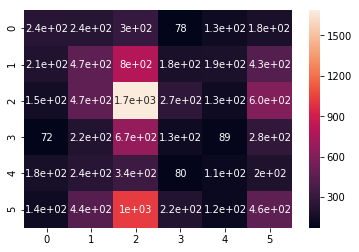

In [294]:
sns.heatmap(cm, annot=True)

In [296]:
print(classification_report(y_test_w2v,y_pred_w2v))

              precision    recall  f1-score   support

           0       0.56      0.21      0.30      1179
           1       0.21      0.01      0.02      2285
           2       0.45      0.09      0.15      3312
           3       0.13      0.01      0.01      1468
           4       0.40      0.01      0.01      1155
           5       0.21      0.93      0.35      2401

   micro avg       0.24      0.24      0.24     11800
   macro avg       0.33      0.21      0.14     11800
weighted avg       0.32      0.24      0.15     11800



### 4. Random forest

In [375]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0, class_weight="balanced")
clf.fit(X_train_w2v, y_train_w2v)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [376]:
y_pred_w2v=clf.predict(X_test_w2v)

In [377]:
# calculating confusion matrix 
cm = confusion_matrix(y_test_w2v, y_pred_w2v) 
cm

array([[ 883,   27,  149,   28,   73,   19],
       [1150,  156,  619,   80,  188,   92],
       [ 886,  195, 1705,  126,  238,  162],
       [ 490,   84,  634,   73,  126,   61],
       [ 734,   52,  225,   32,   85,   27],
       [ 937,  147,  861,   99,  212,  145]])

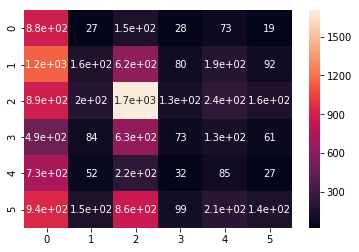

In [379]:
sns.heatmap(cm, annot=True)

In [378]:
print(classification_report(y_test_w2v,y_pred_w2v))

              precision    recall  f1-score   support

           0       0.17      0.75      0.28      1179
           1       0.24      0.07      0.11      2285
           2       0.41      0.51      0.45      3312
           3       0.17      0.05      0.08      1468
           4       0.09      0.07      0.08      1155
           5       0.29      0.06      0.10      2401

   micro avg       0.26      0.26      0.26     11800
   macro avg       0.23      0.25      0.18     11800
weighted avg       0.27      0.26      0.21     11800



### 5. Decision Tree

#### --------- BOW dataset

## Fine Tuning

In [385]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#### 4. Random forest (RandomCVSearch)

In [382]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [ ]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = random_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train_w2v, y_train_w2v)
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_w2v, y_test_w2v)


Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 15.3min
